In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import preprocessing, plotting
sns.set(style='darkgrid')
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, recall_score
from sklearn.model_selection import cross_validate, cross_val_predict


In [8]:
# data loading
questions = pd.read_csv('data/question_data.csv', sep=';')
questions = questions.set_index('Unnamed: 0')  # set first column (question number) as index
questions.index = questions.index.rename('q_id')

In [9]:
data = pd.read_parquet('data/train.parquet')
political_belief = 'q212813'
data.rename({'q212813': 'political_belief'}, axis=1, inplace=True)
data.rename({'Unnamed: 0': 'user_id'}, axis=1, inplace=True)

# Top K descriptive questions df

In [10]:
descriptive_questions = [column for column in data.columns if column.startswith('q')] + ['gender']
#questions.loc['gender', :] = None
questions.loc['gender', 'text'] = 'Gender?'
display(questions.loc[descriptive_questions].head())

,text,option_1,option_2,option_3,option_4,N,Type,Order,Keywords
q_id,,,,,,,,,
q49,Which word describes you better?,Carefree,Intense,NaN,NaN,49827.0,N,NaN,descriptive
q50,Have you ever seen a therapist?,Yes,No,NaN,NaN,9507.0,O,NaN,descriptive
q60,Which describes you better?,Warm-hearted,Cool-headed,NaN,NaN,21205.0,O,NaN,descriptive
q61,Are you a better conversationalist or listener?,Conversationalist,Listener,NaN,NaN,3174.0,O,NaN,descriptive
q63,Which word describes you better?,Private,Social,NaN,NaN,23765.0,O,NaN,descriptive


In [11]:
# per question count number of times the question is answered
n_answers_per_question = data[descriptive_questions].count(axis=0)
sorted_questions = n_answers_per_question.sort_values(ascending=False).index
question_data = questions.join(n_answers_per_question.to_frame('n_answers')) 
display(questions.loc[sorted_questions[:10]][['text']])

,text
q416235,Do you like watching foreign movies with subti...
q85419,Which type of wine would you prefer to drink o...
gender,Gender?
q358084,Do you enjoy intense intellectual conversations?
q501,Have you smoked a cigarette in the last 6 months?
q77,How frequently do you drink alcohol?
q20930,Rate your self-confidence:
q29829,How often do you keep your promises?
q35660,How often are you open with your feelings?
q80,What's your deal with harder drugs (stuff beyo...


In [74]:
subset_descriptive_df = data[descriptive_questions]
print(subset_descriptive_df.shape)

(36085, 830)


In [65]:
K=200
subset_size_topk = [subset_descriptive_df.loc[:, sorted_questions[:k]].dropna().shape[0] for k in range(1, K)]

In [66]:
# biggest k with >=10.000 subjects who answered ALL k questions
n_most_answered = next(x[0] for x in enumerate(subset_size_topk) if x[1] < 25000)
n_most_answered

12

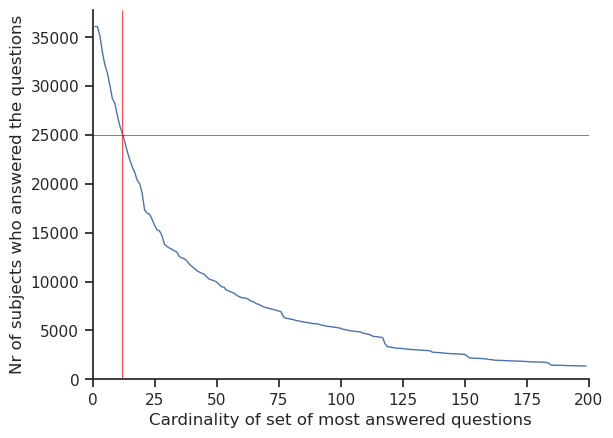

In [67]:
sns.set_style("white")
sns.set_style("ticks")
g = sns.lineplot(x = range(1,K), y = subset_size_topk, linewidth=1)
g.axhline(y=25000, color='red', linewidth=0.5)
g.axvline(x=n_most_answered, color='red', linewidth=0.5)

plt.xlim(0, 200)
plt.ylim(0)
sns.despine()
#plt.ylim(0,len(features_df))
g.set(xlabel ="Cardinality of set of most answered questions", ylabel = "Nr of subjects who answered the questions")
#title ='Nr of subjects who answered the same k most anwered questions '
#plt.figtext(0.5, -0.1, 'Grouping most answered questions into a set, comparing the number of questions in the set to the number of subjects who answered all questions in the set', wrap=True, horizontalalignment='center', fontsize=12)
plt.show()

# Stratification

In [69]:
top_questions = sorted_questions[:n_most_answered].to_list()
filter_by = top_questions + ['political_belief']
stratified_df = data[filter_by].dropna()
n_conservative = stratified_df.groupby('political_belief').count().iloc[1, 0]
stratified_df = stratified_df.groupby('political_belief', group_keys=False).apply(lambda x: x.sample(n=n_conservative, random_state=1))
display(stratified_df)


,q416235,q85419,gender,q358084,q501,q77,q20930,q29829,q35660,q80,q4018,q79,political_belief
index,,,,,,,,,,,,,
66268,Yes,"Red (such as Merlot, Cabernet, Shiraz).",Man,Yes,No,Sometimes,Higher than average,Whenever possible,Usually,I never do drugs.,Yes,Never.,Centrist
56871,No,I don't drink wine.,Man,Yes,Yes,Sometimes,Average,Whenever possible,Rarely,"I've done drugs in the past, but no longer.",Yes,"I smoked in the past, but no longer.",Centrist
22765,Can't answer without a subtitle,Rosé (such as White Zinfindel).,Man,Yes,Yes,Rarely,Average,Whenever possible,Usually,I never do drugs.,Yes,"I smoked in the past, but no longer.",Centrist
62823,Can't answer without a subtitle,"White (such as Chardonnay, Riesling).",Man,Yes,No,Rarely,Higher than average,Whenever possible,Usually,I never do drugs.,Yes,Never.,Centrist
57861,Yes,"Red (such as Merlot, Cabernet, Shiraz).",Man,Yes,No,Rarely,"Very, very high",Whenever possible,Usually,"I've done drugs in the past, but no longer.",Yes,"I smoked in the past, but no longer.",Centrist
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64792,Can't answer without a subtitle,Rosé (such as White Zinfindel).,Man,Yes,Yes,Rarely,Average,Whenever possible,Usually,"I've done drugs in the past, but no longer.",Yes,"I smoked in the past, but no longer.",Other
31169,Yes,"White (such as Chardonnay, Riesling).",Woman,Yes,No,Rarely,Average,Whenever possible,Usually,I never do drugs.,Yes,Never.,Other
34383,No,Rosé (such as White Zinfindel).,Man,Yes,Yes,Sometimes,Higher than average,Always,Usually,I never do drugs.,Yes,Never.,Other


# Question distribution

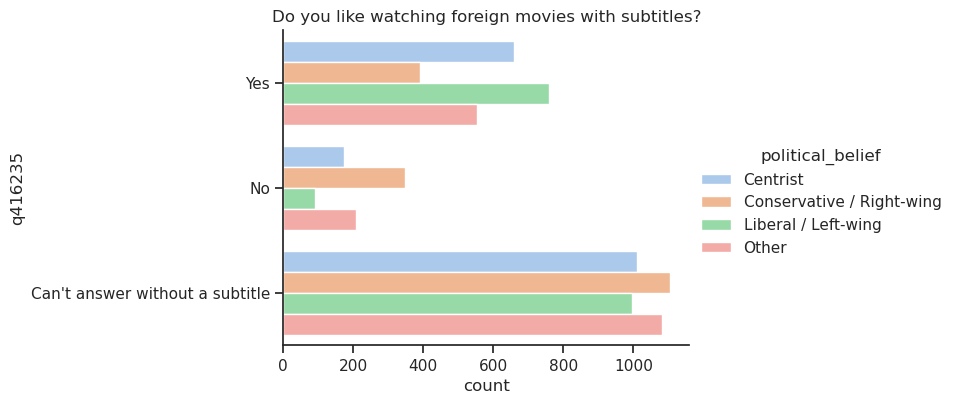

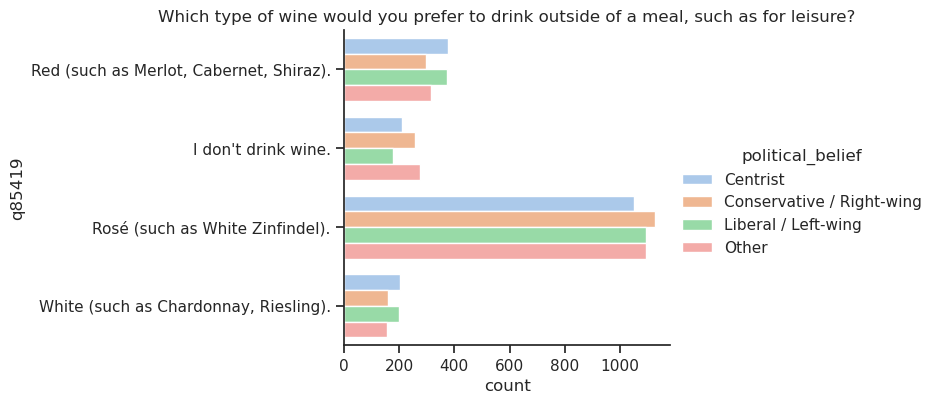

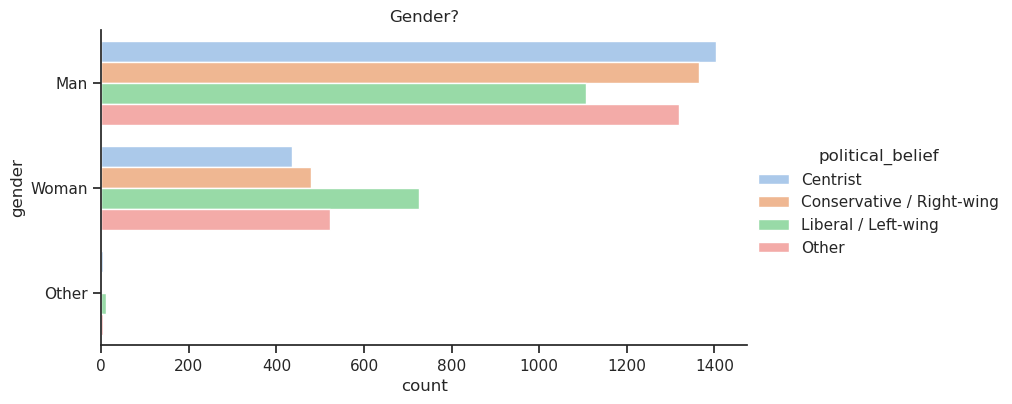

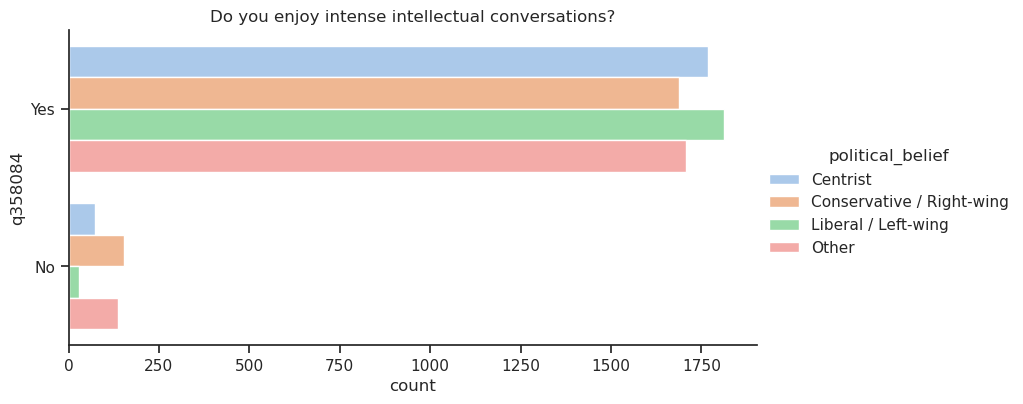

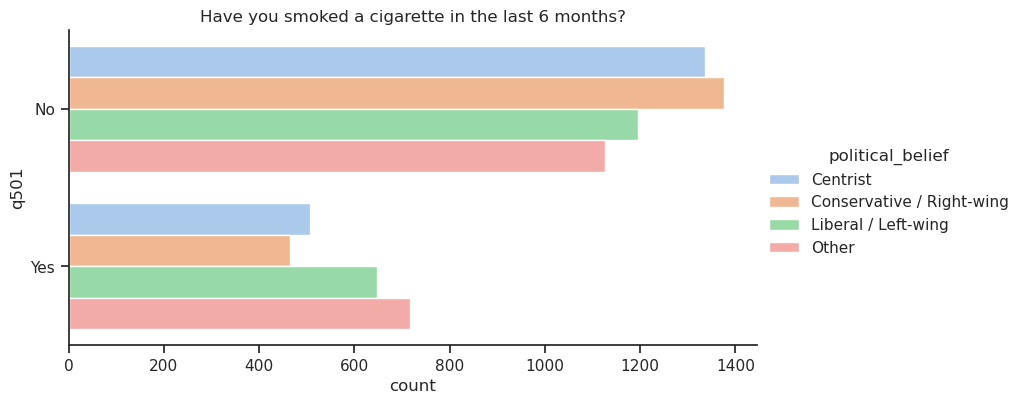

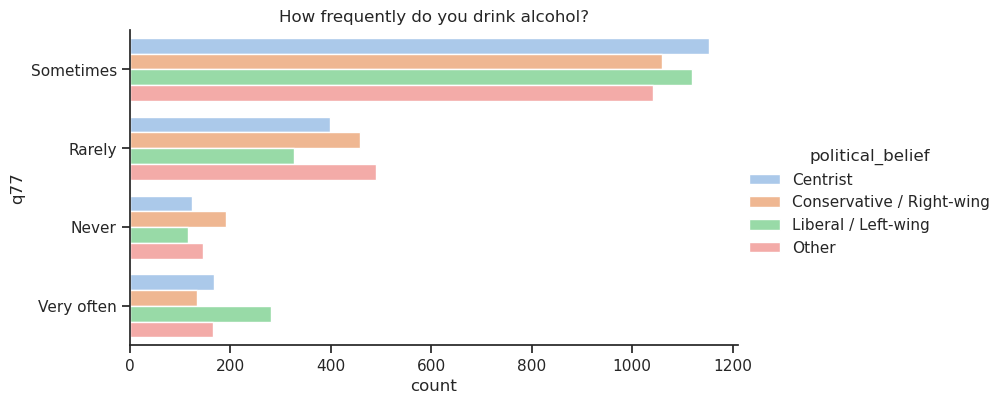

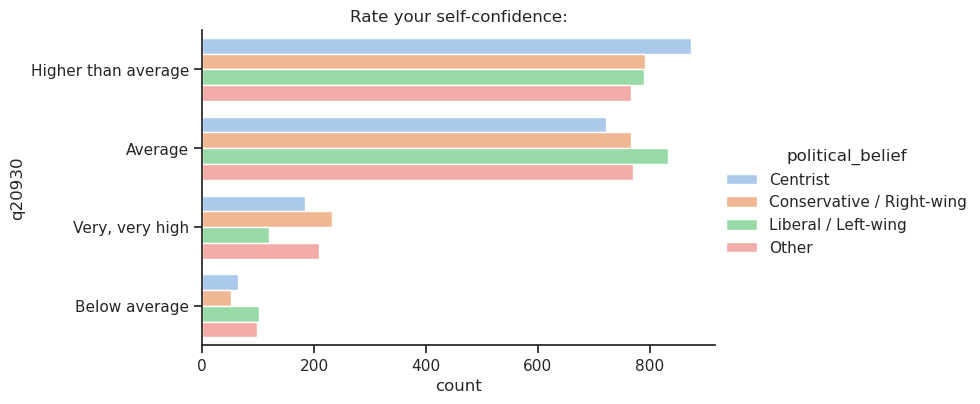

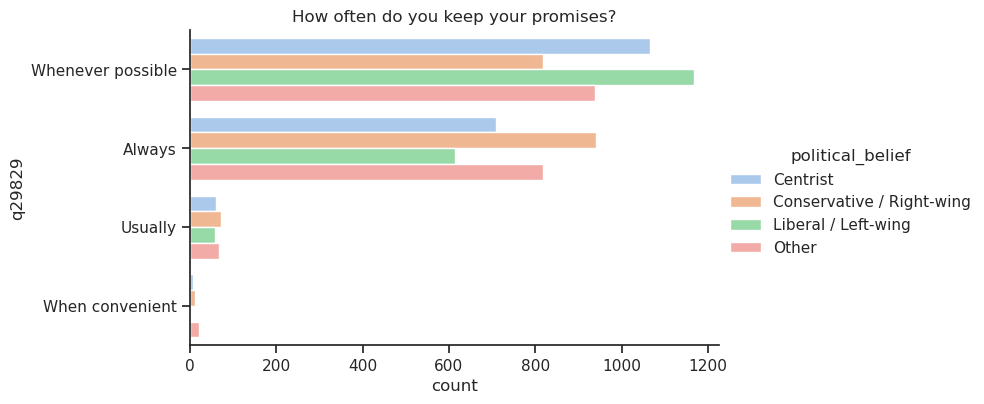

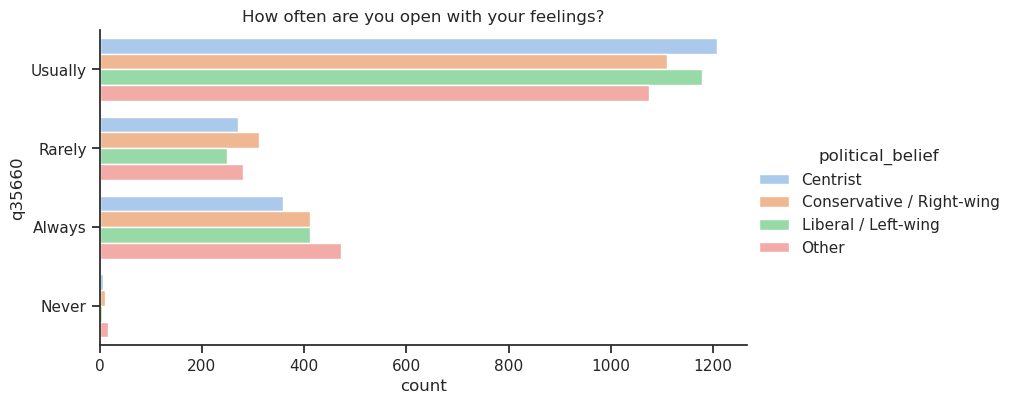

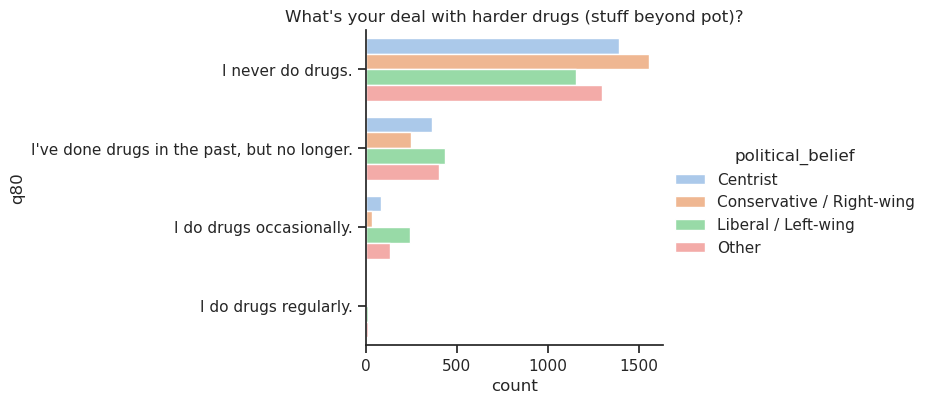

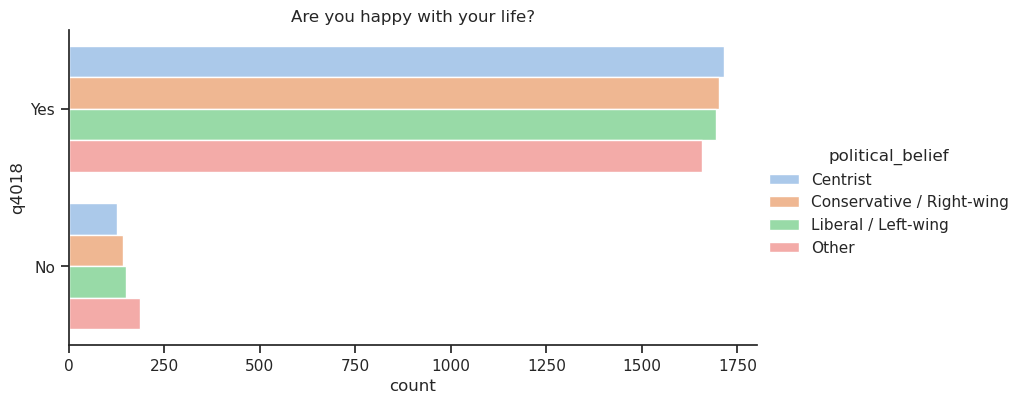

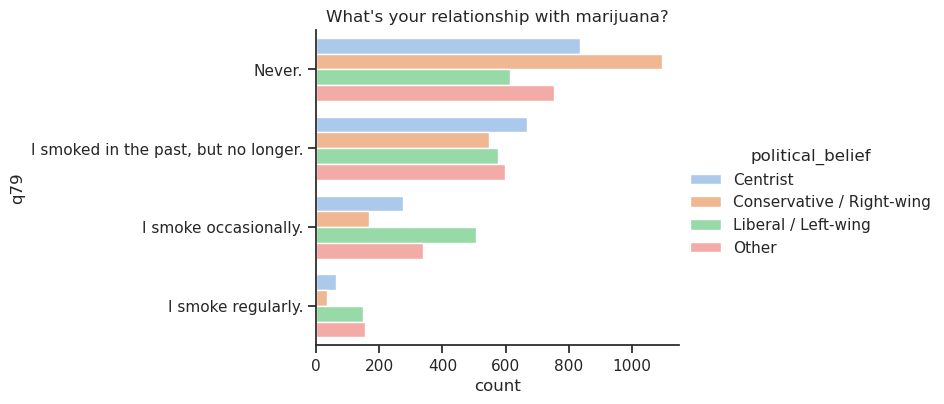

In [122]:
def plot_question_distribution(question: str, data: pd.DataFrame, questions: pd.DataFrame):
    """plots histogram of polical orientation for a given question"""
    title = questions.loc[question, 'text']
    sns.catplot(
        data=data, y=question, kind="count", hue='political_belief', palette="pastel", aspect=2, height = 4).set(title=title)

for question in top_questions:
    plot_question_distribution(question, stratified_df, questions)

# Feature Encoding und Selection

In [80]:
# split into features and target
features_df = stratified_df[top_questions]
target = stratified_df.loc[features_df.index][['political_belief']]

In [76]:
# X_train, X_val, y_train, y_val = train_test_split(features_df, target, test_size=0.15, random_state=1)
# X_train.shape, X_val.shape
# feature_encoder = OneHotEncoder()
# target_encoder = OneHotEncoder()
# X_train_encoded = feature_encoder.fit_transform(X_train)
# y_train_encoded = target_encoder.fit_transform(y_train)
# X_val_encoded = feature_encoder.fit(X_val)
# y_val_encoded = feature_encoder.fit(y_val)

In [77]:
feature_encoder = OrdinalEncoder()
target_encoder = LabelEncoder()
X_train_encoded = feature_encoder.fit_transform(features_df)
y_train_encoded = target_encoder.fit_transform(target.values.ravel())

In [85]:
fs = SelectKBest(score_func=chi2, k=12)
fs.fit(X_train_encoded, y_train_encoded)
X_train_best_feat = fs.transform(X_train_encoded)
display(X_train_best_feat.shape)
fs.scores_.shape
selected_questions = np.argpartition(fs.scores_, 0)[0:]
selected_questions = selected_questions[np.argsort(fs.scores_[selected_questions])][::-1]
 

(7372, 12)

Feature 0: What's your relationship with marijuana?: 227.57150441304233
Feature 1: Gender?: 188.73911039410746
Feature 2: How often do you keep your promises?: 186.73359324237254
Feature 3: Do you like watching foreign movies with subtitles?: 94.84218129288925
Feature 4: Have you smoked a cigarette in the last 6 months?: 71.1095890410987
Feature 5: How frequently do you drink alcohol?: 33.76310802274296
Feature 6: Rate your self-confidence:: 27.821579532815342
Feature 7: How often are you open with your feelings?: 17.81513026052174
Feature 8: What's your deal with harder drugs (stuff beyond pot)?: 10.35531087228893
Feature 9: Which type of wine would you prefer to drink outside of a meal, such as for leisure?: 6.512525499796259
Feature 10: Do you enjoy intense intellectual conversations?: 5.683765582461895
Feature 11: Are you happy with your life?: 1.1129008423230822


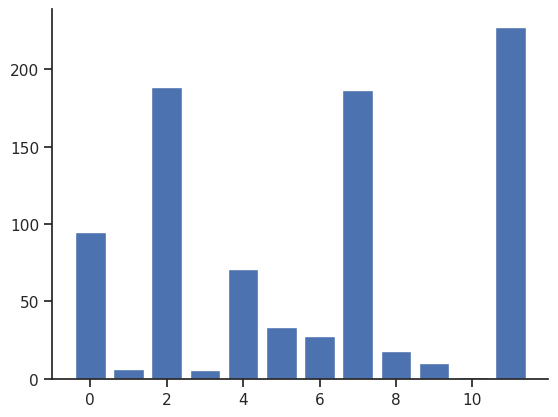

In [86]:
for i, score in enumerate(fs.scores_[selected_questions]):
    print(f'Feature {i}: {questions.loc[sorted_questions[selected_questions[i]]].text}: {score}')

# plot the scores
plt.bar(range(len(fs.scores_)), fs.scores_)
sns.despine()
plt.show()

# Model Selection

In [87]:
# Naive Bayes Hyper parameter Tuning
parameters = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
nb = CategoricalNB(fit_prior=False)
clf = GridSearchCV(nb, parameters, scoring='balanced_accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)

mean test score [0.37548236 0.37548236 0.37534649 0.37534612 0.373719   0.37493814
 0.36612687]
best estimator CategoricalNB(alpha=0.001, fit_prior=False)


In [88]:
# Logistic Regression
# one hot encoding for Logistic Regression 
feature_encoder = OneHotEncoder()
X_train_best_feat_1hot = feature_encoder.fit_transform(X_train_best_feat)
print(X_train_best_feat_1hot.shape)

(7372, 40)


In [89]:
parameters = {'C': [0.001, 0.01, 1, 10, 100]}
logreg = LogisticRegression(solver='lbfgs', class_weight='balanced', max_iter=1000, random_state=42)
clf = GridSearchCV(logreg, parameters, scoring='balanced_accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat_1hot, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)


mean test score [0.3707295  0.37805541 0.38104012 0.38117709 0.38117673]
best estimator LogisticRegression(C=10, class_weight='balanced', max_iter=1000,
                   random_state=42)


In [90]:
parameters = { 
    'n_estimators': [50, 500],
    'min_samples_leaf' : [0.1, 5, 10],
}

# Fitting Random Forest Classification to the Training set
rf = RandomForestClassifier(criterion='entropy', random_state=42, class_weight='balanced')
clf = GridSearchCV(rf, parameters, scoring='balanced_accuracy', cv=5)  # stratified per default
clf.fit(X_train_best_feat_1hot, y_train_encoded)
sorted(clf.cv_results_.keys())
print('mean test score', clf.cv_results_['mean_test_score'])
print('best estimator', clf.best_estimator_)

mean test score [0.35038662 0.35743306 0.35661784 0.36068583 0.36381451 0.36652638]
best estimator RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       min_samples_leaf=10, n_estimators=500, random_state=42)


# Evaluation

In [111]:
# Naive Bayes
clf = CategoricalNB(fit_prior=False)
y_pred = cross_val_predict(clf, X_train_best_feat, y_train_encoded, cv=10)
conf_mat = confusion_matrix(y_train_encoded, y_pred)
crossval_accuracy = accuracy_score(y_train_encoded, y_pred)
f1_score = f1_score(y_train_encoded, y_pred, average='weighted')
recall_score = recall_score(y_train_encoded, y_pred, average='weighted')
print('crossval accuracy', crossval_accuracy)
print('f1 ', f1_score)
print('recall ', recall_score)
print(conf_mat)


crossval accuracy 0.3752034725990233
f1  0.36165498623542586
recall  0.3752034725990233
[[ 518  650  453  222]
 [ 346 1020  225  252]
 [ 355  413  869  206]
 [ 320  660  504  359]]


### To-Dos:
- Data Distribution 
- Cross Validation for the 3 best model configurations
- Compute Confustion Matrix and other evaluations
- Decide which classifier to use
- Significance test
- Random features: scramble targets --> significance test

### Questions for Auguste:
- One-hot passt?
- Reicht balanced bei model? -> nicht features angepasst
- Signifance test?

# Data Distributions

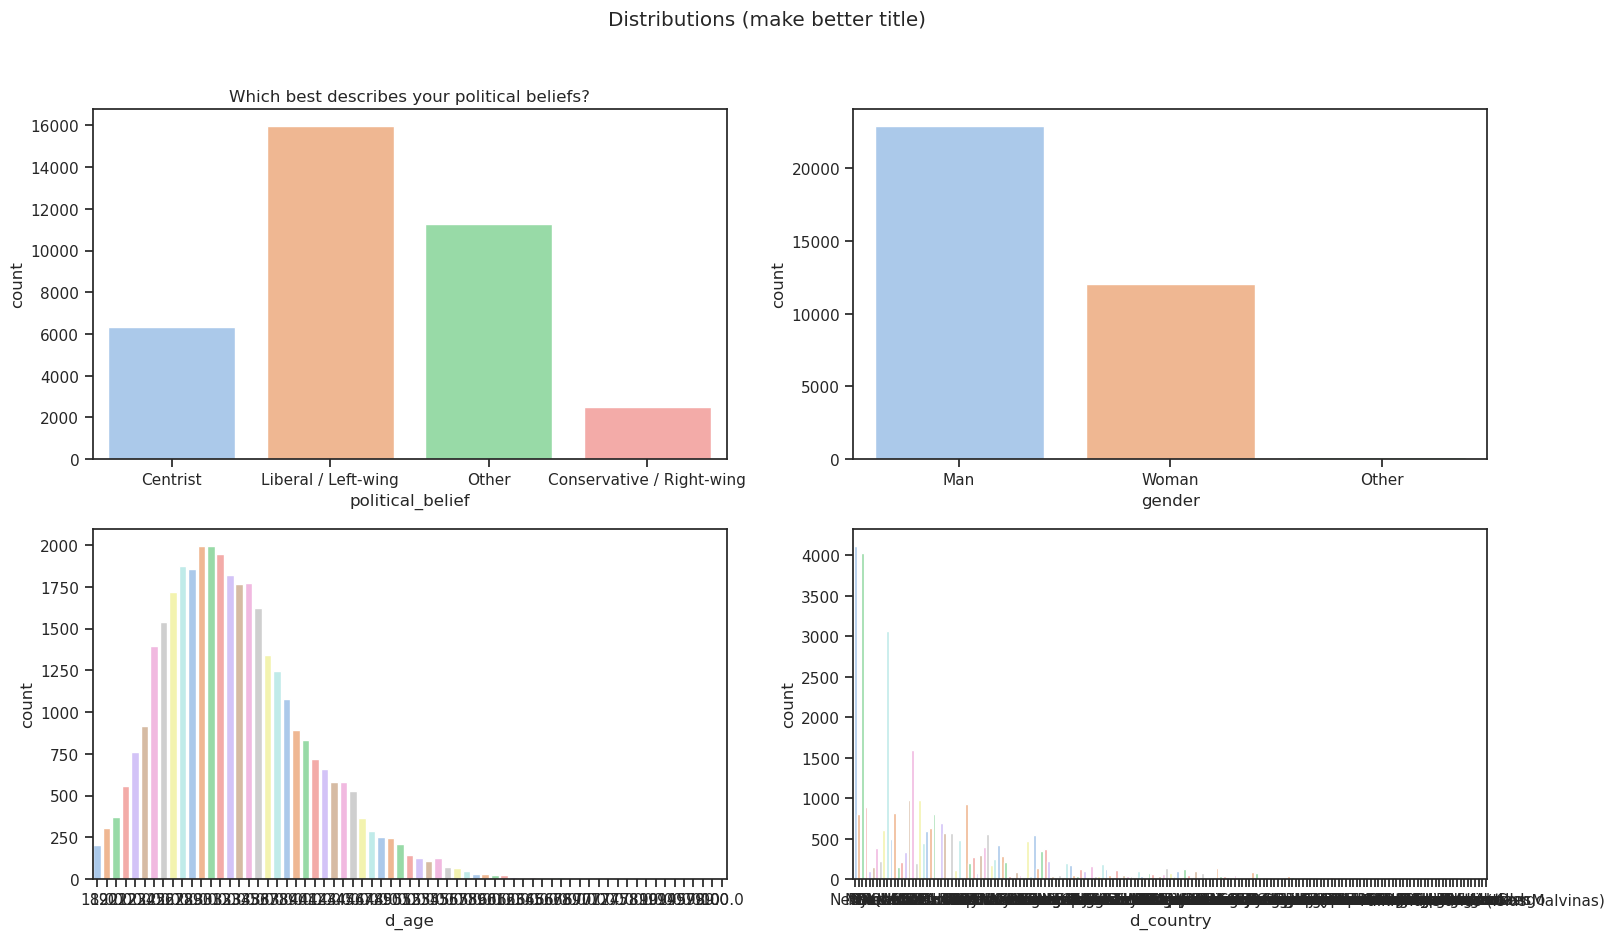

In [112]:
fig, axes = plt.subplots(2, 2, figsize=(18, 10))
 
fig.suptitle('Distributions (make better title)')

 
sns.countplot(ax=axes[0, 0], data=data, x='political_belief', palette="pastel").set(title=questions.loc['q212813', 'text'])
sns.countplot(ax=axes[0, 1], data=data, x='gender', palette="pastel")
sns.countplot(ax=axes[1, 0], data=data, x='d_age', palette="pastel")
sns.countplot(ax=axes[1, 1], data=data, x='d_country', palette="pastel")
plt.show()

In [ ]:
descriptive_questions = [column for column in data.columns if column.startswith('q')]
data['n_q_answered'] = data[descriptive_questions].count(axis=1)

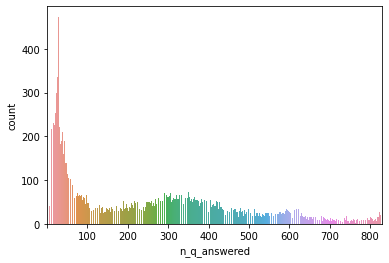

In [ ]:
ax = sns.countplot(x=data['n_q_answered'])
ax.set_xticks(range(-2, data['n_q_answered'].max(), 100))
plt.show()